In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

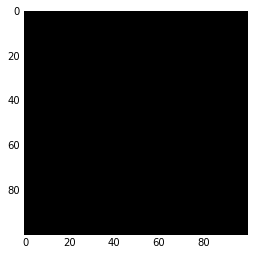

In [152]:
S = np.zeros((100, 100), dtype = np.uint8)
plt.imshow(S)

In [104]:
def drawObstacle(img, (x, y), r):
    cv2.circle(img, (int(x), int(y)), r, (255), -1)
    #plt.imshow(img)
    #plt.imsave("dwdew.png", a)
    return img

In [143]:
#function to add obstacles to the global state on basis of the update from the laser scan
def predictGlobalState(state_map):
    b, thresh = cv2.threshold(state_map, 127, 255, cv2.THRESH_BINARY)
    #print thresh
    #plt.imshow(thresh)
    connectivity = 4  
    # Perform the operation
    c_idx, labels, stats, centroid = cv2.connectedComponentsWithStats(thresh, connectivity)
    obstacle_radius = 6
    #for each centroid (not background), create an obstacle
    for c in centroid:
        state_map = drawObstacle(state_map, (c[0], c[1]), obstacle_radius)
    return state_map

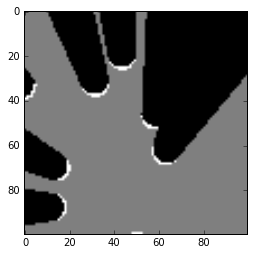

In [155]:
scan_1 = cv2.imread('temp_1.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(scan_1)

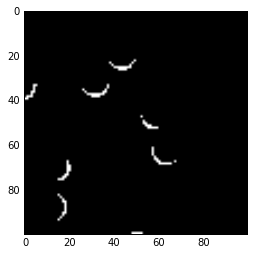

In [158]:
S[scan_1 == 255] = 255
plt.imshow(S)

In [159]:
S = predictGlobalState(S)

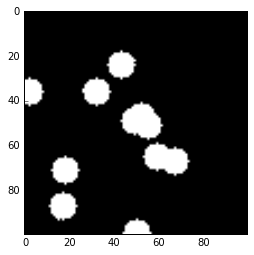

In [160]:
plt.imshow(S)

In [150]:
s1

array([[  0,   0,   0, ..., 127, 127, 127],
       [  0,   0,   0, ..., 127, 127, 127],
       [  0,   0,   0, ..., 127, 127, 127],
       ..., 
       [  0,   0,   0, ..., 127, 127, 127],
       [  0,   0,   0, ..., 127, 127, 127],
       [  0,   0,   0, ..., 127, 127, 127]], dtype=uint8)